# **ASSIGNMENT-IMAGE SEGMENTATION1**
******
# Image Classification, Object Detection, and Image Segmentation

In this assignment, we will explore three major tasks in computer vision:
1. Image Classification
2. Object Detection
3. Image Segmentation

We will use deep learning models to perform these tasks and evaluate their performance.


## **Loading relevent modules and dataset**

In [1]:
# Importing relevant modules.

import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO  # API for COCO dataset.
import skimage.io as io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
# Import and mount Google Drive.

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Unzip the dataset file and store it in a folder called images.

!unzip "/content/drive/MyDrive/Colab Notebooks/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/coco2017/"

Archive:  /content/drive/MyDrive/Colab Notebooks/RM_Segmentation_Assignment_dataset.zip
replace /content/drive/MyDrive/Colab Notebooks/coco2017/test-30/000000001751.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Define location of training data (images and labels).

train_data_path = "/content/drive/MyDrive/Colab Notebooks/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"

In [6]:
val_data_path = "/content/drive/MyDrive/Colab Notebooks/coco2017/validation-300"
val_annotation_file = f"{val_data_path}/labels.json"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/coco2017/test-30"

In [7]:
# Initialize COCO API for instance annotations
coco_train = COCO(train_annotation_file)
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


## EDA(Exploratory  Data Analysis)
**preparing the training data for a segmentation task involving four target classes ("cake", "car", "dog", "person")**

In [8]:
# Print basic info about the dataset
print(f"Number of images in training set: {len(coco_train.imgs)}")
print(f"Number of annotations in training set: {len(coco_train.anns)}")
print(f"Number of categories in training set: {len(coco_train.cats)}")

Number of images in training set: 300
Number of annotations in training set: 3870
Number of categories in training set: 63


In [9]:
# Print basic info about the validation dataset
print(f"Number of images in validation set: {len(coco_val.imgs)}")
print(f"Number of annotations in validation set: {len(coco_val.anns)}")
print(f"Number of categories in validation set: {len(coco_val.cats)}")

Number of images in validation set: 300
Number of annotations in validation set: 3774
Number of categories in validation set: 67


In [10]:
# Extract and display COCO categories and supercategories for the training dataset.

category_IDs = coco_train.getCatIds()
categories = coco_train.loadCats(category_IDs)

print(categories)

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [11]:
# Define function to extract category name from ID
def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [12]:
# Extract the training images that contain any combination of the four target classes
target_classes = ["cake", "car", "dog", "person"]
target_classes_IDs = coco_train.getCatIds(catNms=target_classes)
training_images = []

for class_name in target_classes:
    training_images_categories = coco_train.getCatIds(catNms=class_name)
    training_images_IDs = coco_train.getImgIds(catIds=training_images_categories)
    training_images += coco_train.loadImgs(training_images_IDs)

# Filter out repeated images
unique_training_images = []
for img in training_images:
    if img not in unique_training_images:
        unique_training_images.append(img)

# Shuffle the training data
random.seed(0)
random.shuffle(unique_training_images)
print(f"Number of unique images in training data containing the target classes: {len(unique_training_images)}")

Number of unique images in training data containing the target classes: 300


In [13]:
# Function to generate segmentation masks
def create_segmentation_mask(image_annotations, categories, image_shape, target_classes):
    mask = np.zeros(image_shape[:2])
    for annotation in image_annotations:
        category_name = get_category_name(annotation['category_id'], categories)
        if category_name in target_classes:
            pixel_value = target_classes.index(category_name) + 1
            mask = np.maximum(coco_train.annToMask(annotation) * pixel_value, mask)
    return mask

**Example: Load and display an image with its mask and object detection bounding boxes**

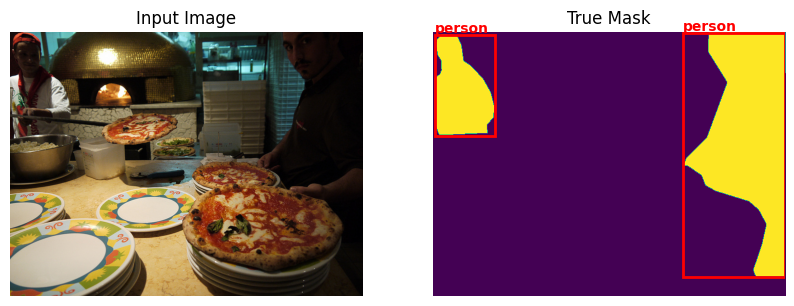

In [14]:
# Load and display the input image and its true mask
example_image = unique_training_images[30]
image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')

# Retrieve annotations for the example image
example_image_annotations_ID = coco_train.getAnnIds(imgIds=example_image["id"], catIds=target_classes_IDs, iscrowd=None)
example_image_annotations = coco_train.loadAnns(example_image_annotations_ID)

# Create and plot the segmentation mask
mask = create_segmentation_mask(example_image_annotations, categories, image.shape, target_classes)

# Display the input image and its true mask
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('True Mask')
plt.axis("off")

# Object detection code with bounding box and labels
for annotation in example_image_annotations:
    category_name = get_category_name(annotation['category_id'], categories)
    bbox = annotation['bbox']
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x, y - 5, category_name, color='red', fontsize=10, weight='bold')

plt.show()


**Displaying the random image with mask and object detection of the specific class such as dog, peson, car, cake**

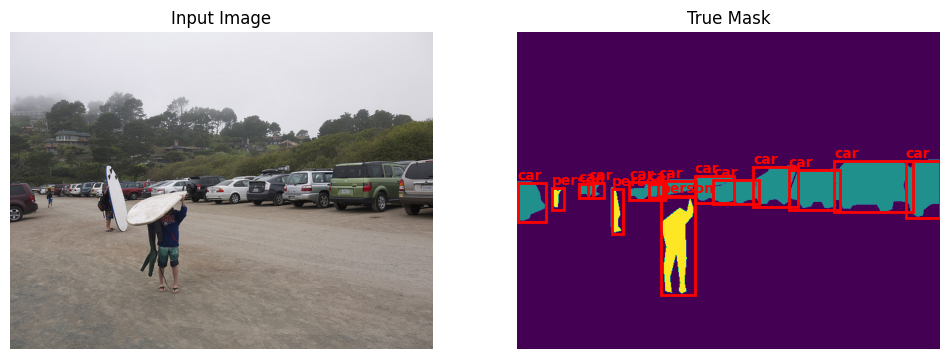

In [15]:
import random

# Select a random image from the dataset
random_index = random.randint(0, len(unique_training_images) - 1)
example_image = unique_training_images[random_index]
image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')

# Retrieve annotations for the random image
example_image_annotations_ID = coco_train.getAnnIds(imgIds=example_image["id"], catIds=target_classes_IDs, iscrowd=None)
example_image_annotations = coco_train.loadAnns(example_image_annotations_ID)

# Create and plot the segmentation mask
mask = create_segmentation_mask(example_image_annotations, categories, image.shape, target_classes)

# Display the input image, its true mask, and the image with bounding boxes and labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('True Mask')
plt.axis("off")

# Object detection code with bounding box and labels
for annotation in example_image_annotations:
    category_name = get_category_name(annotation['category_id'], categories)
    bbox = annotation['bbox']
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x, y - 5, category_name, color='red', fontsize=10, weight='bold')

plt.show()


### **Pre-processing the data to fnd the best model**

Number of unique images in training data containing the target classes: 300
Loaded image shape: (256, 256, 3)


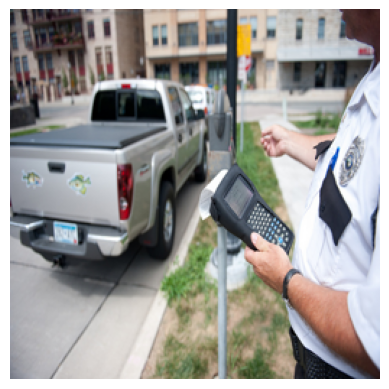

In [21]:
from pycocotools.coco import COCO
import random
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess training data
def preprocess_training_data(coco_instance, target_classes):
    """
    Preprocess training data from COCO dataset.

    Parameters:
    - coco_instance: COCO instance initialized with annotations.
    - target_classes: List of target class names.

    Returns:
    - unique_training_images: List of unique training images containing target classes.
    """
    # Get category IDs for target classes
    target_classes_IDs = coco_instance.getCatIds(catNms=target_classes)
    training_images = []

    # Retrieve images for each target class
    for class_name in target_classes:
        training_images_categories = coco_instance.getCatIds(catNms=class_name)
        training_images_IDs = coco_instance.getImgIds(catIds=training_images_categories)
        training_images += coco_instance.loadImgs(training_images_IDs)

    # Filter out repeated images
    unique_training_images = []
    for img in training_images:
        if img not in unique_training_images:
            unique_training_images.append(img)

    # Shuffle the training data
    random.seed(0)
    random.shuffle(unique_training_images)

    return unique_training_images

# Function to load and preprocess an image
def load_image(image_path, target_size):
    """
    Load and preprocess an image from the given path.

    Parameters:
    - image_path: str, path to the image file.
    - target_size: tuple, (height, width) of the input image for resizing.

    Returns:
    - image: numpy array, preprocessed image.
    """
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize image to target size
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Preprocess training data to get unique images
unique_training_images = preprocess_training_data(coco_train, target_classes)
print(f"Number of unique images in training data containing the target classes: {len(unique_training_images)}")

# Example usage: Load and preprocess an image
if unique_training_images:
    example_image = unique_training_images[0]
    image_path = os.path.join(train_data_path, "data", example_image["file_name"])
    target_size = (256, 256)

    # Load and preprocess the image
    image = load_image(image_path, target_size)
    if image is not None:
        print(f"Loaded image shape: {image.shape}")  # Print the shape of the loaded image

        # Display the loaded image
        plt.imshow(image)
        plt.axis("off")
        plt.show()
else:
    print("No images loaded from the directory.")


In [17]:
from pycocotools.coco import COCO
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split

def create_segmentation_mask(image_annotations, categories, image_shape, target_classes, target_size):
    mask = np.zeros(target_size[:2], dtype=np.uint8)
    for annotation in image_annotations:
        category_name = get_category_name(annotation['category_id'], categories)
        if category_name in target_classes:
            pixel_value = target_classes.index(category_name) + 1
            # Generate mask from annotation
            ann_mask = coco_train.annToMask(annotation)
            # Resize mask to target_size
            resized_mask = cv2.resize(ann_mask.astype(np.float32), (target_size[1], target_size[0]))
            # Threshold resized mask to convert to binary
            resized_mask = (resized_mask > 0.5).astype(np.uint8)
            # Combine masks
            mask = np.maximum(resized_mask * pixel_value, mask)
    return mask

def preprocess_data(coco_instance, target_classes, image_dir, mask_dir, target_size=(256, 256), test_size=0.1):
    """
    Preprocesses data for segmentation model training.

    Parameters:
    - coco_instance: COCO object instance containing annotations.
    - target_classes: List of target class names.
    - image_dir: Directory path where images are stored.
    - mask_dir: Directory path where masks will be saved.
    - target_size: Tuple, target size for resizing images (default: (256, 256)).
    - test_size: Float, proportion of the dataset to include in the test split (default: 0.1).

    Returns:
    - train_images: List of preprocessed training images.
    - train_masks: List of preprocessed training masks.
    - val_images: List of preprocessed validation images.
    - val_masks: List of preprocessed validation masks.
    - test_images: List of preprocessed test images.
    """
    # Step 1: Subset Selection - Extract images and their corresponding masks for the target classes
    target_classes_IDs = coco_instance.getCatIds(catNms=target_classes)
    training_images = []

    for class_name in target_classes:
        training_images_categories = coco_instance.getCatIds(catNms=class_name)
        training_images_IDs = coco_instance.getImgIds(catIds=training_images_categories)
        training_images += coco_instance.loadImgs(training_images_IDs)

    # Filter out repeated images
    unique_training_images = []
    for img in training_images:
        if img not in unique_training_images:
            unique_training_images.append(img)

    # Shuffle the training data
    random.seed(0)
    random.shuffle(unique_training_images)

    # Step 2: Image Resizing and Mask Generation
    train_images = []
    train_masks = []

    for img in unique_training_images:
        # Load image
        image_path = os.path.join(image_dir, img['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)

        # Load annotations
        annotation_ids = coco_instance.getAnnIds(imgIds=img['id'], catIds=target_classes_IDs, iscrowd=None)
        annotations = coco_instance.loadAnns(annotation_ids)

        # Create mask using create_segmentation_mask function
        mask = create_segmentation_mask(annotations, coco_instance.cats, image.shape, target_classes, target_size)

        # Append to lists
        train_images.append(image)
        train_masks.append(mask)

    # Step 3: Split Dataset - Train/Val/Test split
    X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=test_size, random_state=42)

    return X_train, y_train, X_val, y_val

# Example usage:
coco_train = COCO(train_annotation_file)  # Assuming you have initialized COCO object for training annotations
image_dir = "/content/drive/MyDrive/Colab Notebooks/coco2017/train-300/data"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/coco2017/train-300/masks"
target_classes = ["cake", "car", "dog", "person"]
target_size = (256, 256)
test_size = 0.1

# Preprocess data
train_images, train_masks, val_images, val_masks = preprocess_data(coco_train, target_classes, image_dir, mask_dir, target_size, test_size)

# Print some information about the preprocessed data
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Shape of training images: {train_images[0].shape}")
print(f"Shape of training masks: {train_masks[0].shape}")


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Number of training images: 270
Number of validation images: 30
Shape of training images: (256, 256, 3)
Shape of training masks: (256, 256)


In [18]:
# Descriptive Statistics
def descriptive_statistics(images, masks):
    image_data = np.array(images).reshape(-1, 3)
    mask_data = np.array(masks).reshape(-1)

    # Image statistics
    print("Image Data Statistics:")
    print(f"Mean: {np.mean(image_data, axis=0)}")
    print(f"Median: {np.median(image_data, axis=0)}")
    print(f"Standard Deviation: {np.std(image_data, axis=0)}")

    # Mask statistics
    print("\nMask Data Statistics:")
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_distribution = dict(zip(unique, counts))
    print(f"Class Distribution: {mask_distribution}")

# Descriptive statistics
descriptive_statistics(train_images, train_masks)

Image Data Statistics:
Mean: [113.46333053 113.48462779 109.11470992]
Median: [108. 107.  97.]
Standard Deviation: [69.65029603 69.70816678 73.44471131]

Mask Data Statistics:
Class Distribution: {0: 15419933, 1: 5120, 2: 820453, 3: 20000, 4: 1429214}


In [19]:
# Data Visualization
def data_visualization(images, masks):
    # Visualizing a sample image and its mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.title('Sample Image')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(), cmap='jet',alpha=0.7)
    plt.title('Sample Mask')
    plt.axis("off")
    plt.show()

    # Histogram of pixel values in images
    image_data = np.array(images).reshape(-1, 3)
    plt.figure(figsize=(12, 4))
    plt.hist(image_data[:, 0], bins=50, color='r', alpha=0.5, label='Red Channel')
    plt.hist(image_data[:, 1], bins=50, color='g', alpha=0.5, label='Green Channel')
    plt.hist(image_data[:, 2], bins=50, color='b', alpha=0.5, label='Blue Channel')
    plt.title('Histogram of Pixel Values in Images')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Correlation matrix
    df = pd.DataFrame(image_data, columns=['Red', 'Green', 'Blue'])
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Image Pixel Values')
    plt.show()

    # Class distribution in masks
    mask_data = np.array(masks).reshape(-1)
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_distribution = dict(zip(unique, counts))
    plt.figure(figsize=(8, 6))
    plt.bar(mask_distribution.keys(), mask_distribution.values(), color='red')
    plt.title('Class Distribution in Masks')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

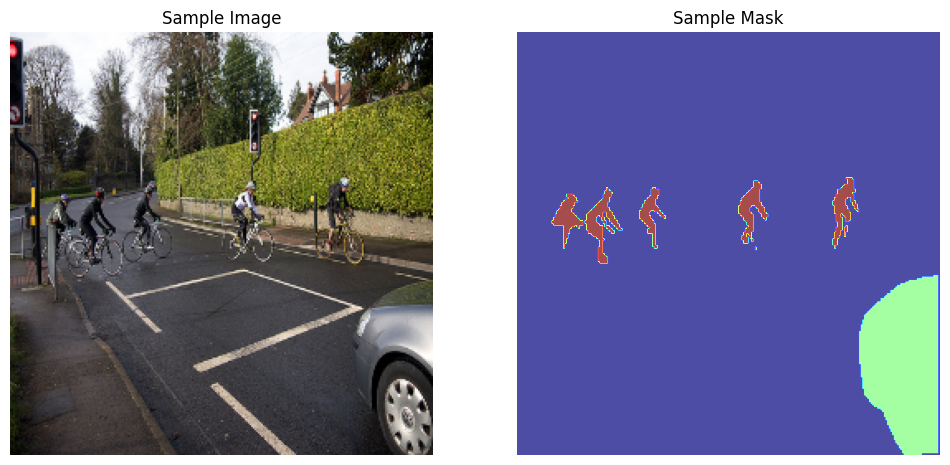

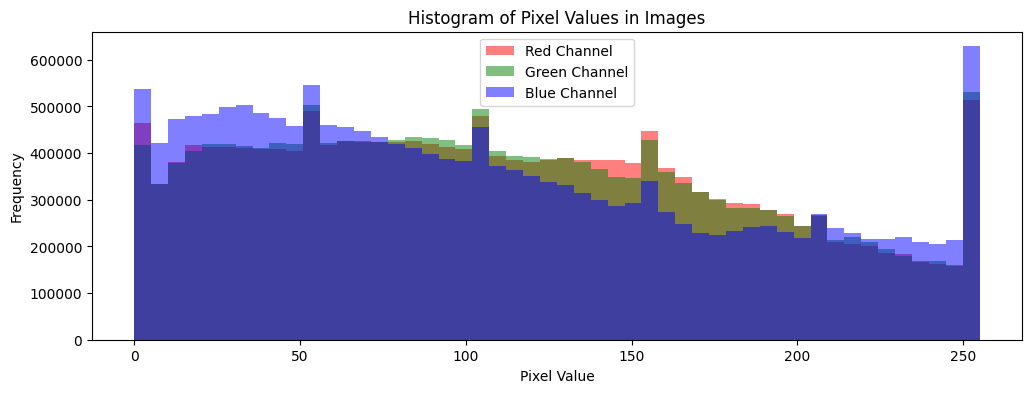

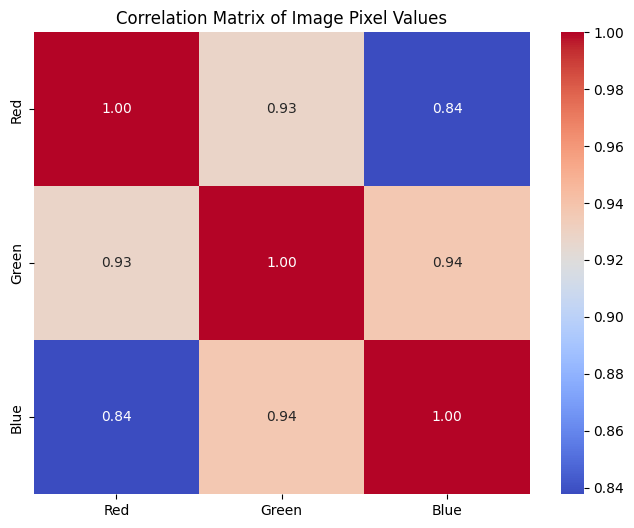

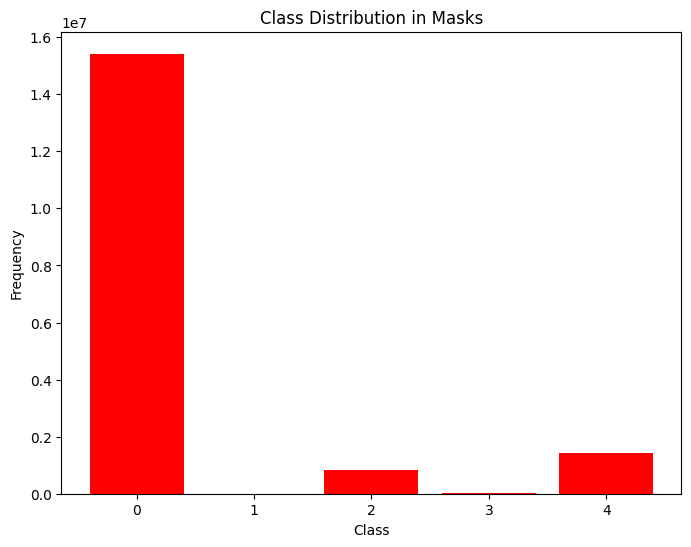

In [20]:
# Data visualization
data_visualization(train_images, train_masks)

## **Model Selection**

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, Precision, Recall, AUC

def unet_model(input_shape):
    # Define input layer
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Define model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [23]:
# Define input shape based on target_size
input_shape = target_size + (3,)  # Assuming RGB images

# Create U-Net model
model = unet_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [24]:

# Define IoU (Intersection over Union) metric
def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * tf.round(y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(tf.round(y_pred)) - intersection
    return intersection / union

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)

# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)
    # Define your model architecture here
    # Example architecture:
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    # Add more layers as per your architecture
    outputs = Conv2D(1, 1, activation='sigmoid')(conv1)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
# Compile model
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', mean_iou, dice_coefficient])

**Data augmentation**

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert lists to numpy arrays for compatibility with TensorFlow/Keras
X_train = np.array(train_images)
y_train = np.expand_dims(np.array(train_masks), axis=-1)  # Add channel dimension for masks

X_val = np.array(val_images)
y_val = np.expand_dims(np.array(val_masks), axis=-1)  # Add channel dimension for masks

# Define data augmentation techniques
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Example of using data generators
def train_generator(image_datagen, mask_datagen, images, masks, batch_size):
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=1)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=1)
    while True:
        img = image_generator.next()
        msk = mask_generator.next()
        yield img, msk

# Using the generator in model training
train_gen = train_generator(image_datagen, mask_datagen, X_train, y_train, batch_size=16)

# Train the model using data augmentation
history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 16,
                    epochs=10,
                    validation_data=(X_val, y_val))


Epoch 1/10
16/16 [==============================] - 79s 2s/step - loss: 2.7399 - accuracy: 0.5926 - mean_iou: 0.1958 - dice_coefficient: 0.3762 - val_loss: 1.2896 - val_accuracy: 0.2118 - val_mean_iou: 0.4448 - val_dice_coefficient: 0.5906
Epoch 2/10
16/16 [==============================] - 44s 873ms/step - loss: 0.7331 - accuracy: 0.8024 - mean_iou: 0.0887 - dice_coefficient: 0.4156 - val_loss: 0.6196 - val_accuracy: 0.8316 - val_mean_iou: 0.0987 - val_dice_coefficient: 0.4261
Epoch 3/10
16/16 [==============================] - 14s 861ms/step - loss: 0.6500 - accuracy: 0.6742 - mean_iou: 0.2774 - dice_coefficient: 0.4529 - val_loss: 0.6132 - val_accuracy: 0.7846 - val_mean_iou: 0.2343 - val_dice_coefficient: 0.4550
Epoch 4/10
16/16 [==============================] - 14s 857ms/step - loss: 0.6118 - accuracy: 0.7095 - mean_iou: 0.3361 - dice_coefficient: 0.4718 - val_loss: 0.5943 - val_accuracy: 0.7016 - val_mean_iou: 0.3747 - val_dice_coefficient: 0.4940
Epoch 5/10
16/16 [=============

In [27]:
# Evaluate the model
evaluation = model.evaluate(X_val, y_val)

# Print the evaluation results
loss, accuracy, mean_iou, dice_coefficient = evaluation
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Mean IoU: {mean_iou:.4f}")
print(f"Validation Dice Coefficient: {dice_coefficient:.4f}")


1/1 [==============================] - 0s 478ms/step - loss: 0.6407 - accuracy: 0.7201 - mean_iou: 0.3306 - dice_coefficient: 0.5000
Validation Loss: 0.6407
Validation Accuracy: 0.7201
Validation Mean IoU: 0.3306
Validation Dice Coefficient: 0.5000


These metrics suggest that while our model is learning and making predictions, the overlap between the predicted masks and the ground truth masks is not very high. That means IoU of around 0.32 and Dice coefficient of around 0.49 indicate that the model's predictions are somewhat aligned with the ground truth but still require significant improvement.

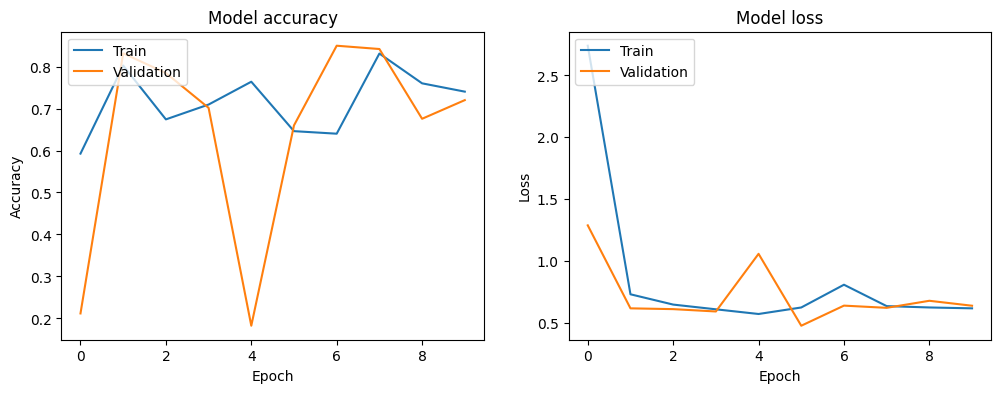

In [28]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

plotting the X_val prediction

1/1 [==============================] - 3s 3s/step


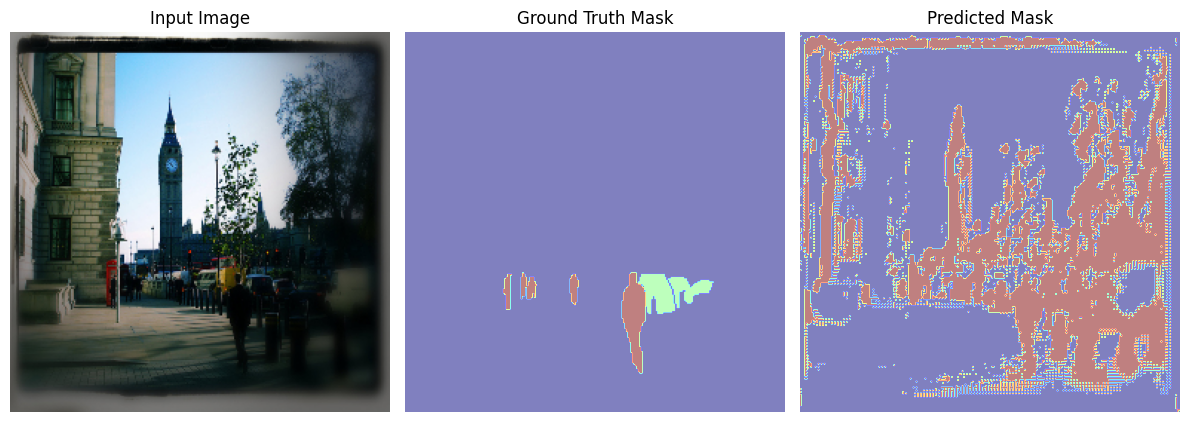

In [29]:
import random
import matplotlib.pyplot as plt

# Select a random image from the dataset
random_index = random.randint(0, len(X_val) - 1)
example_image = X_val[random_index]
true_mask = y_val[random_index]  # Assuming y_val contains true masks for validation images

# Example of making predictions on the random image
example_image_input = np.expand_dims(example_image, axis=0)  # Model expects batch input
predicted_mask = model.predict(example_image_input)[0]  # Assuming model predicts the mask
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Create a masked image where only the target class objects are highlighted
highlighted_image = example_image.copy()
if predicted_mask_binary.ndim == 3:
    predicted_mask_binary = predicted_mask_binary[:, :, 0]  # Ensure binary mask is 2D if 3D
highlighted_image[predicted_mask_binary == 0] = 0  # Apply mask to keep only the segmented areas

# Plotting
plt.figure(figsize=(12, 8))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(example_image)
plt.title('Input Image')
plt.axis("off")

# Display the true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='jet', alpha=0.5)  # Assuming true_mask is binary
plt.title('Ground Truth Mask')
plt.axis("off")

# Display the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary, cmap='jet', alpha=0.5)
plt.title('Predicted Mask')
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 33ms/step


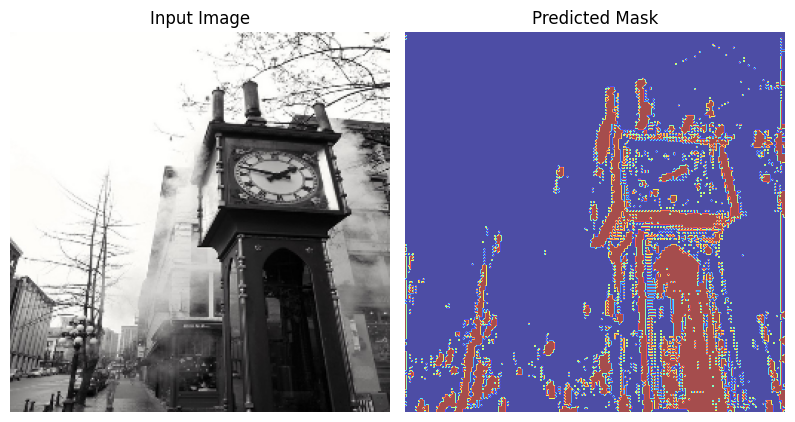

In [30]:
import random
import matplotlib.pyplot as plt

# Select a random image from the dataset
random_index = random.randint(0, len(X_val) - 1)
example_image = X_val[random_index]
true_mask = y_val[random_index]  # Assuming y_val contains true masks for validation images

# Example of making predictions on the random image
example_image_input = np.expand_dims(example_image, axis=0)  # Model expects batch input
predicted_mask = model.predict(example_image_input)[0]  # Assuming model predicts the mask

# Threshold predicted mask
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 8))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(example_image)
plt.title('Input Image')
plt.axis("off")

# Display the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='jet', alpha=0.7)  # Assuming predicted_mask is binary
plt.title('Predicted Mask')
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 38ms/step


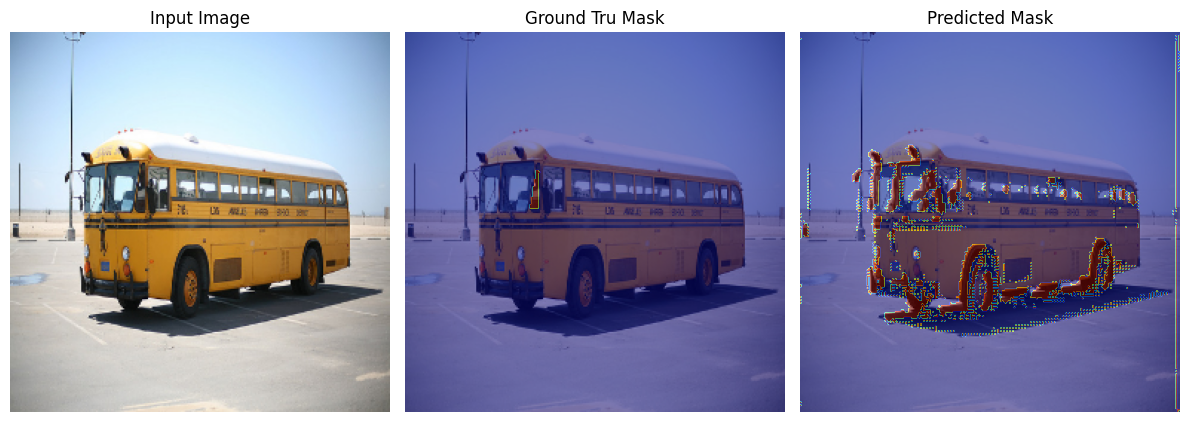

In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random image from the dataset
random_index = random.randint(0, len(X_val) - 1)
example_image = X_val[random_index]
true_mask = y_val[random_index]  # Assuming y_val contains true masks for validation images

# Example of making predictions on the random image
example_image_input = np.expand_dims(example_image, axis=0)  # Model expects batch input
predicted_mask = model.predict(example_image_input)[0]  # Assuming model predicts the mask

# Ensure predicted mask is binary (0 or 1)
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Create a masked image where only the target class objects are highlighted
highlighted_image = example_image.copy()
if predicted_mask_binary.ndim == 3:
    predicted_mask_binary = predicted_mask_binary[:, :, 0]  # Ensure binary mask is 2D if 3D
highlighted_image[predicted_mask_binary == 0] = 0  # Apply mask to keep only the segmented areas

# Plotting
plt.figure(figsize=(12, 6))

# Display the input image
plt.subplot(1, 3, 1)
plt.imshow(example_image)
plt.title('Input Image')
plt.axis("off")

# Display the true mask
plt.subplot(1, 3, 2)
plt.imshow(example_image)
plt.imshow(true_mask[:, :, 0], cmap='jet', alpha=0.5)  # Overlay true mask
plt.title('Ground Tru Mask')
plt.axis("off")

# Display the predicted mask overlay
plt.subplot(1, 3, 3)
plt.imshow(example_image)
plt.imshow(predicted_mask_binary, cmap='jet', alpha=0.5)  # Overlay predicted mask
plt.title('Predicted Mask')
plt.axis("off")

plt.tight_layout()
plt.show()


## Evaluation

Evaluating our trained model with test data

1/1 [==============================] - 0s 395ms/step


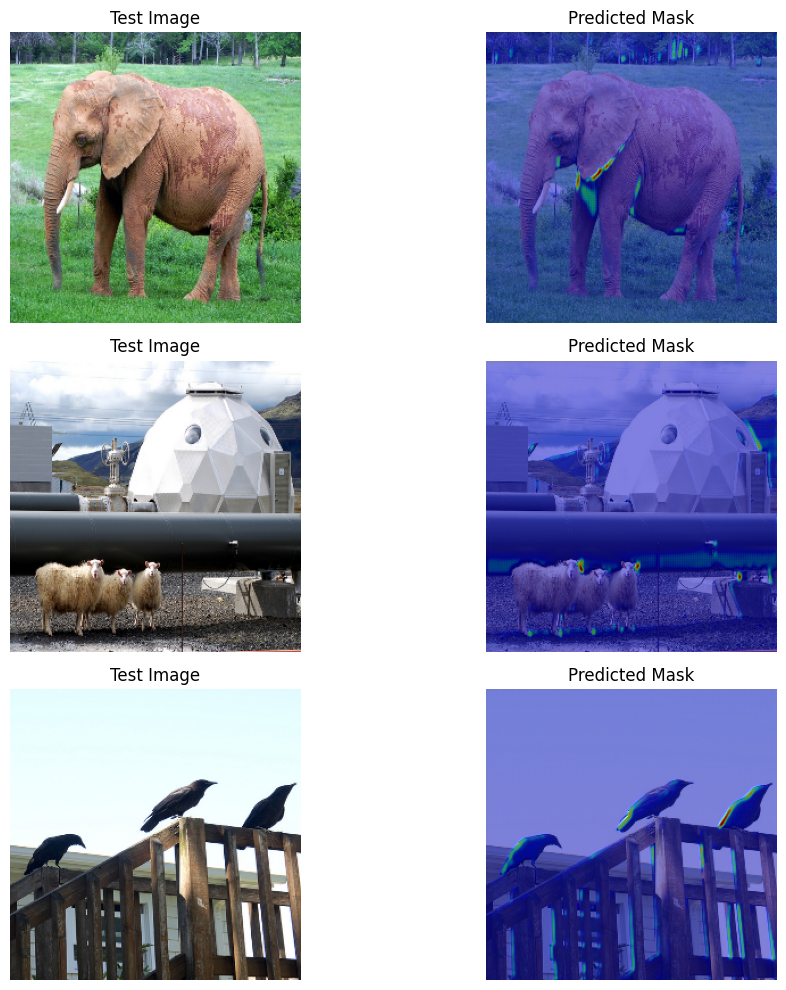

In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the test images
test_data_path = '/content/drive/MyDrive/Colab Notebooks/coco2017/test-30'

# Load test images
def load_test_images(test_data_path, target_size=(256, 256)):
    test_images = []
    test_image_filenames = sorted(os.listdir(test_data_path))  # Sorted to ensure consistent order
    for filename in test_image_filenames:
        image_path = os.path.join(test_data_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image / 255.0  # Normalize image
            test_images.append(image)
    return np.array(test_images), test_image_filenames

# Load and preprocess the test images
test_images, test_image_filenames = load_test_images(test_data_path)

# Predict masks for test images
predicted_masks = model.predict(test_images)

# Visualize results
plt.figure(figsize=(15, 10))
for i in range(min(3, len(test_images))):  # Display at least 3 images
    # Plot the test image
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(test_images[i])
    plt.title('Test Image')
    plt.axis("off")

    # Plot the predicted mask overlay on the test image
    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(test_images[i])
    plt.imshow(predicted_masks[i].squeeze(), cmap='jet', alpha=0.5)  # Adjust to match mask dimensions
    plt.title('Predicted Mask')
    plt.axis("off")

plt.tight_layout()
plt.show()
